# Random forest v AdaBoost

How do random forest and AdaBoost compare with increasing number of estimators?

In [1]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from matplotlib.ticker import MaxNLocator # for integer ticks
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import zero_one_loss
import time
import scipy

## The dataset

We use here an old dataset on spam emails. I've chosen it for two reasons:
* it's fairly small (~4600 samples), which is good because we're going to repeat training several times
* it's a binary classification problem -- the multiclass implementation of AdaBoost behaves in a weird way

In [2]:
from sklearn.datasets import fetch_openml
data = fetch_openml('spambase', cache=True)
print(data.DESCR)
X, y = data["data"], data["target"]
X=X.values
train_size=4000
X.shape

/home/henning/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**Author**: Mark Hopkins, Erik Reeber, George Forman, Jaap Suermondt    
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/spambase)   
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

SPAM E-mail Database  
The "spam" concept is diverse: advertisements for products/websites, make money fast schemes, chain letters, pornography... Our collection of spam e-mails came from our postmaster and individuals who had filed spam.  Our collection of non-spam e-mails came from filed work and personal e-mails, and hence the word 'george' and the area code '650' are indicators of non-spam.  These are useful when constructing a personalized spam filter.  One would either have to blind such non-spam indicators or get a very wide collection of non-spam to generate a general purpose spam filter.
 
For background on spam:  
Cranor, Lorrie F., LaMacchia, Brian A.  Spam! Communications of the ACM, 41(8):74-83, 1998.  

### Attribute Information:  
The last column denotes

(4601, 57)

We need a method that restricts the majority decision to only a subset of the ensemble. (I want to avoid training many random forest classifiers with different numbers of estimators: That's time consuming and unnecessary as all trees are trained independently of each other anyway.)

In [3]:
def majority(rf,X,num_trees):
    trees=rf.estimators_[:num_trees]
    return rf.classes_[np.argmax(
        np.mean(
            [tree.predict_proba(X) for tree in trees],axis=0),axis=1)] 

Next, let's vary the number of estimators and record training and test error. For statistical stability we repeat each experiment 40 times.

In [4]:
repeats=40
n_estimators=20
results_train=[]
results_test=[]
start=2
end=n_estimators+1
start_time=time.time()
for _ in range(repeats):
    X, y = sklearn.utils.shuffle(X,y)
    X_train,X_test=X[:train_size],X[train_size:]
    y_train,y_test=y[:train_size],y[train_size:]
    rf=RandomForestClassifier(n_estimators=n_estimators)
    rf.fit(X_train,y_train)    

    train_errs_by_round=[zero_one_loss(majority(rf,X_train,num_trees),y_train) for num_trees in range(start,end)]
    test_errs_by_round=[zero_one_loss(majority(rf,X_test,num_trees),y_test) for num_trees in range(start,end)]
    results_train.append(train_errs_by_round)
    results_test.append(test_errs_by_round)

train_errs=np.mean(results_train,axis=0)
test_errs=np.mean(results_test,axis=0)
print("running time: {:.1f}s".format(time.time()-start_time))

running time: 22.5s


Next, we do the same for AdaBoost. The inbuilt method <code>staged_predict</code> allows us to see how only the first $k$ estimators decide.

In [5]:
repeats=40
train_errs_by_round=[]
test_errs_by_round=[]
start_time=time.time()
for r in range(repeats):
    ada=AdaBoostClassifier(n_estimators=100)
    X, y = sklearn.utils.shuffle(X,y)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    ada.fit(X_train,y_train)
    train_errs_by_round.append([zero_one_loss(y_train,pred) for pred in ada.staged_predict(X_train)])
    test_errs_by_round.append([zero_one_loss(y_test,pred) for pred in ada.staged_predict(X_test)])
train_errs_ada=np.array(train_errs_by_round).mean(axis=0)
test_errs_ada=np.array(test_errs_by_round).mean(axis=0)
print("running time: {:.1f}s".format(time.time()-start_time))

running time: 113.6s


...and let's plot the results.

Text(0.5, 1.0, 'AdaBoost')

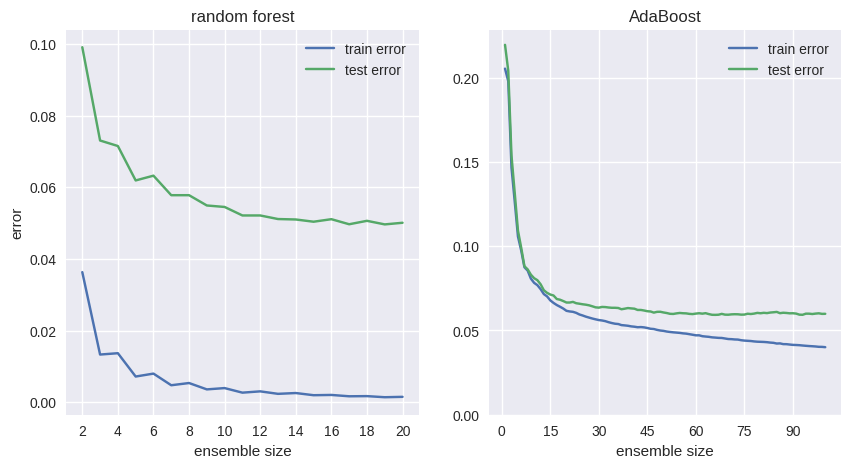

In [6]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(range(start,end),train_errs,label="train error")
axs[0].plot(range(start,end),test_errs,label="test error")
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].legend()
axs[0].set_xlabel('ensemble size')
axs[0].set_ylabel('error')
axs[0].set_title('random forest')

axs[1].plot(range(1,len(train_errs_ada)+1),train_errs_ada,label="train error")
axs[1].plot(range(1,len(test_errs_ada)+1),test_errs_ada,label="test error")
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].legend()
axs[1].set_ylim(bottom=0)
axs[1].set_xlabel('ensemble size')
axs[1].set_title('AdaBoost')

We observe for random forest:
* Random forest starts with a high gap between training and test error that stays mostly constant as more estimators are added.
* Training error shrinks with increased number of estimators.
* Given that the decision trees are fully grown, why is there a positive training error at all? Because due to bootstrapping some ensemble members will not have seen some of the datapoints during training. (Repeating the experiment with switched off bootstrapping is quite enlightening.)

For AdaBoost, we observe:
* AdaBoost starts with a very small gap between training and test error that increases as more estimators are added.
* Training error shrinks with increased number of estimators.
* With larger number of estimators, AdaBoost clearly starts overfitting.